<a href="https://colab.research.google.com/github/Shereen74/graduation_project/blob/main/Predictions_ProphetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/GP

/content/drive/MyDrive/GP


In [2]:
!pwd

/content/drive/MyDrive/GP


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Note to self: These files are without feature scaling!

In [4]:
train_daily_x = pd.read_csv('./train_daily_x.csv', keep_default_na=False, index_col=None)
train_daily_y = pd.read_csv('./train_daily_y.csv', keep_default_na=False, index_col=None)
test_daily_x = pd.read_csv('./test_daily_x.csv', keep_default_na=False, index_col=None)
test_daily_y = pd.read_csv('./test_daily_y.csv', keep_default_na=False, index_col=None)

# Simple preprocessing

In [5]:
# Converting month, day, hour back to timestamp 

train_daily_x['month'] = pd.to_numeric(train_daily_x['month'], errors='coerce')
train_daily_x['day'] = pd.to_numeric(train_daily_x['day'], errors='coerce')
train_daily_x['hour'] = pd.to_numeric(train_daily_x['hour'], errors='coerce')

train_daily_x['timestamp'] = pd.to_datetime('2016-' + train_daily_x['month'].astype(str) + '-' + train_daily_x['day'].astype(str) + ' ' + train_daily_x['hour'].astype(str) + ':00:00')
# Print any rows with invalid dates
print(train_daily_x[train_daily_x['timestamp'].isnull()])

# Remove rows with invalid dates
train_daily_x = train_daily_x.dropna(subset=['timestamp'])

# Reset the index if needed
train_daily_x = train_daily_x.reset_index(drop=True)

Empty DataFrame
Columns: [site_id, day, month, building_id, meter, square_feet, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_speed, IsHoliday, hour, weekend, primary_use_Education, primary_use_Entertainment/public assembly, primary_use_Food sales and service, primary_use_Healthcare, primary_use_Lodging/residential, primary_use_Manufacturing/industrial, primary_use_Office, primary_use_Other, primary_use_Parking, primary_use_Public services, primary_use_Religious worship, primary_use_Retail, primary_use_Services, primary_use_Technology/science, primary_use_Utility, primary_use_Warehouse/storage, timestamp]
Index: []

[0 rows x 32 columns]


In [6]:
# Converting month, day, hour back to timestamp 

test_daily_x['month'] = pd.to_numeric(test_daily_x['month'], errors='coerce')
test_daily_x['day'] = pd.to_numeric(test_daily_x['day'], errors='coerce')
test_daily_x['hour'] = pd.to_numeric(test_daily_x['hour'], errors='coerce')

test_daily_x['timestamp'] = pd.to_datetime('2016-' + test_daily_x['month'].astype(str) + '-' + test_daily_x['day'].astype(str) + ' ' + test_daily_x['hour'].astype(str) + ':00:00')

# Print any rows with invalid dates
print(test_daily_x[test_daily_x['timestamp'].isnull()])

# Remove rows with invalid dates
test_daily_x = test_daily_x.dropna(subset=['timestamp'])

# Reset the index if needed
test_daily_x = test_daily_x.reset_index(drop=True)

Empty DataFrame
Columns: [site_id, day, month, building_id, meter, square_feet, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_speed, IsHoliday, hour, weekend, primary_use_Education, primary_use_Entertainment/public assembly, primary_use_Food sales and service, primary_use_Healthcare, primary_use_Lodging/residential, primary_use_Manufacturing/industrial, primary_use_Office, primary_use_Other, primary_use_Parking, primary_use_Public services, primary_use_Religious worship, primary_use_Retail, primary_use_Services, primary_use_Technology/science, primary_use_Utility, primary_use_Warehouse/storage, timestamp]
Index: []

[0 rows x 32 columns]


In [7]:
train_daily_x = train_daily_x.drop(['month', 'day', 'hour'], axis=1)
test_daily_x = test_daily_x.drop(['month', 'day', 'hour'], axis=1)

In [8]:
train_daily_x

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp
0,0,0,0,7432.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00:00:00
1,0,1,0,2720.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00:00:00
2,0,2,0,5376.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00:00:00
3,0,3,0,23685.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00:00:00
4,0,4,0,116607.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13346740,15,1444,0,19619.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,0,2016-08-31 23:00:00
13346741,15,1445,0,4298.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,0,2016-08-31 23:00:00
13346742,15,1446,0,11265.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,0,2016-08-31 23:00:00
13346743,15,1447,0,29775.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,0,2016-08-31 23:00:00


Adding the target variable to my train data

In [9]:
train_daily_x = train_daily_x.assign(meter_reading_log1p=train_daily_y['meter_reading_log1p'])

In [10]:
train_daily_x

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp,meter_reading_log1p
0,0,0,0,7432.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
1,0,1,0,2720.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
2,0,2,0,5376.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
3,0,3,0,23685.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
4,0,4,0,116607.0,25.0,6.000000,20.0,-0.173913,1019.70000,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13346740,15,1444,0,19619.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,2016-08-31 23:00:00,2.630089
13346741,15,1445,0,4298.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,2016-08-31 23:00:00,1.266948
13346742,15,1446,0,11265.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,2016-08-31 23:00:00,1.341558
13346743,15,1447,0,29775.0,22.8,0.363636,17.8,-0.198697,1016.39014,2.1,...,0,0,0,0,0,0,0,0,2016-08-31 23:00:00,5.402339


Adding my target variable to my test data

In [11]:
test_daily_x = test_daily_x.assign(meter_reading_log1p=test_daily_y['meter_reading_log1p'])

In [12]:
test_daily_x

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp,meter_reading_log1p
0,0,0,0,7432.0,24.4,8.0,23.3,-1.0,1013.7,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,4.331021
1,0,1,0,2720.0,24.4,8.0,23.3,-1.0,1013.7,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,3.746486
2,0,2,0,5376.0,24.4,8.0,23.3,-1.0,1013.7,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,1.818324
3,0,3,0,23685.0,24.4,8.0,23.3,-1.0,1013.7,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,4.821378
4,0,4,0,116607.0,24.4,8.0,23.3,-1.0,1013.7,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,6.138452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6851784,15,1444,0,19619.0,1.7,2.0,-5.6,-1.0,1008.5,8.8,...,0,0,0,0,0,0,0,0,2016-12-31 23:00:00,2.277267
6851785,15,1445,0,4298.0,1.7,2.0,-5.6,-1.0,1008.5,8.8,...,0,0,0,0,0,0,0,0,2016-12-31 23:00:00,1.762159
6851786,15,1446,0,11265.0,1.7,2.0,-5.6,-1.0,1008.5,8.8,...,0,0,0,0,0,0,0,0,2016-12-31 23:00:00,0.000000
6851787,15,1447,0,29775.0,1.7,2.0,-5.6,-1.0,1008.5,8.8,...,0,0,0,0,0,0,0,0,2016-12-31 23:00:00,5.078761


Extracting data with building id = 0, site id = 0, meter type (electricity),
 applied on train and test

In [13]:
train_id0 = train_daily_x[((train_daily_x.site_id==0) & (train_daily_x.meter==0) & (train_daily_x.building_id == 0))]

In [14]:
train_id0.reset_index(drop=True, inplace=True)

In [15]:
train_id0

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp,meter_reading_log1p
0,0,0,0,7432.0,25.0,6.000000,20.0,-0.173913,1019.7,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 00:00:00,0.000000
1,0,0,0,7432.0,24.4,4.285714,21.1,-1.000000,1020.2,1.5,...,0,0,0,0,0,0,0,0,2016-01-01 01:00:00,0.000000
2,0,0,0,7432.0,22.8,2.000000,21.1,0.000000,1020.2,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 02:00:00,0.000000
3,0,0,0,7432.0,21.1,2.000000,20.6,0.000000,1020.1,0.0,...,0,0,0,0,0,0,0,0,2016-01-01 03:00:00,0.000000
4,0,0,0,7432.0,20.0,2.000000,20.0,-1.000000,1020.0,2.6,...,0,0,0,0,0,0,0,0,2016-01-01 04:00:00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,0,0,0,7432.0,29.4,7.500000,23.3,0.000000,1012.7,4.6,...,0,0,0,0,0,0,0,0,2016-08-31 19:00:00,4.254479
5852,0,0,0,7432.0,28.9,7.500000,23.9,0.000000,1012.1,5.1,...,0,0,0,0,0,0,0,0,2016-08-31 20:00:00,4.251637
5853,0,0,0,7432.0,27.2,7.500000,23.3,-1.000000,1012.2,12.9,...,0,0,0,0,0,0,0,0,2016-08-31 21:00:00,4.279726
5854,0,0,0,7432.0,23.3,7.500000,21.7,51.000000,1012.7,3.1,...,0,0,0,0,0,0,0,0,2016-08-31 22:00:00,4.271384


In [16]:
test_id0 = test_daily_x[((test_daily_x.site_id==0) & (test_daily_x.meter==0) & (test_daily_x.building_id == 0))]

In [17]:
test_id0.reset_index(drop=True, inplace=True)
test_id0

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp,meter_reading_log1p
0,0,0,0,7432.0,24.4,8.000000,23.3,-1.0,1013.7000,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,4.331021
1,0,0,0,7432.0,24.4,8.000000,23.3,10.0,1014.3000,0.0,...,0,0,0,0,0,0,0,0,2016-09-01 01:00:00,4.325745
2,0,0,0,7432.0,23.9,8.000000,22.8,50.0,1013.0696,6.2,...,0,0,0,0,0,0,0,0,2016-09-01 02:00:00,4.331021
3,0,0,0,7432.0,23.9,8.000000,22.8,46.0,1015.0000,2.6,...,0,0,0,0,0,0,0,0,2016-09-01 03:00:00,4.331021
4,0,0,0,7432.0,23.3,8.000000,22.2,10.0,1015.7000,3.6,...,0,0,0,0,0,0,0,0,2016-09-01 04:00:00,4.341492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,0,0,0,7432.0,22.8,2.857143,10.0,0.0,1021.7000,5.7,...,0,0,0,0,0,0,0,0,2016-12-31 19:00:00,4.234396
2924,0,0,0,7432.0,23.3,2.857143,8.9,0.0,1021.0000,4.1,...,0,0,0,0,0,0,0,0,2016-12-31 20:00:00,4.032755
2925,0,0,0,7432.0,23.3,2.857143,10.0,0.0,1021.1000,4.1,...,0,0,0,0,0,0,0,0,2016-12-31 21:00:00,3.928185
2926,0,0,0,7432.0,22.8,2.857143,10.0,0.0,1021.1000,3.1,...,0,0,0,0,0,0,0,0,2016-12-31 22:00:00,3.928185


Copying timestamp and meter reading to a new dataframe for prophet

In [18]:
train_data = train_id0[['timestamp', 'meter_reading_log1p']].copy()
train_data.columns = ['ds', 'y']

In [19]:
test_data = test_id0[['timestamp', 'meter_reading_log1p']].copy()
test_data.columns = ['ds', 'y']

In [20]:
test_data

,ds,y
0,2016-09-01 00:00:00,4.331021
1,2016-09-01 01:00:00,4.325745
2,2016-09-01 02:00:00,4.331021
3,2016-09-01 03:00:00,4.331021
4,2016-09-01 04:00:00,4.341492
...,...,...
2923,2016-12-31 19:00:00,4.234396
2924,2016-12-31 20:00:00,4.032755
2925,2016-12-31 21:00:00,3.928185
2926,2016-12-31 22:00:00,3.928185


In [21]:
# Making sure that the train data has unique values of timestamp
num_unique_timestamps1 = train_id0['timestamp'].nunique()
print(num_unique_timestamps1)

num_unique_timestamps2 = test_id0['timestamp'].nunique()
print(num_unique_timestamps2)

5856
2928


Create MAPE function

In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Prophet Model 1 

In [18]:
%%time
model1 = Prophet()
model1.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyret2bxm/tnagepl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyret2bxm/4cvucd9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95980', 'data', 'file=/tmp/tmpyret2bxm/tnagepl6.json', 'init=/tmp/tmpyret2bxm/4cvucd9j.json', 'output', 'file=/tmp/tmpyret2bxm/prophet_modeltvopwfw3/prophet_model-20230612133333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 368 ms, sys: 19.8 ms, total: 387 ms
Wall time: 2.67 s


In [19]:
forecast_energy = model1.predict(test_data)
forecast_energy[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

,ds,yhat_lower,yhat,yhat_upper
0,2016-09-01 00:00:00,3.982399,4.394975,4.829554
1,2016-09-01 01:00:00,3.960898,4.396414,4.810202
2,2016-09-01 02:00:00,3.970808,4.394774,4.829434
3,2016-09-01 03:00:00,4.002807,4.389486,4.795354
4,2016-09-01 04:00:00,3.959518,4.383855,4.809082
...,...,...,...,...
2923,2016-12-31 19:00:00,-5.538455,4.448909,14.206469
2924,2016-12-31 20:00:00,-5.439952,4.448117,14.262908
2925,2016-12-31 21:00:00,-5.314977,4.443053,14.285918
2926,2016-12-31 22:00:00,-5.409035,4.437047,14.317844


## Model 1 Evaluation 

In [20]:
actual_values1 = test_id0['meter_reading_log1p']
predicted_values1 = forecast_energy['yhat']

In [21]:
# Calculate MSE
mse1 = mean_squared_error(actual_values1, predicted_values1)
# Calculate RMSE
rmse1 = np.sqrt(mse1)
# Calculate MAPE
mape1 = np.mean(np.abs((actual_values1 - predicted_values1) / actual_values1)) * 100
# Calculate MAE
mae1 = mean_absolute_error(actual_values1, predicted_values1)
# Calculate R-squared
r2_1 = r2_score(actual_values1, predicted_values1)

print("Mean Squared Error (MSE) for model 1:", mse1)
print("Root Mean Squared Error (RMSE) for model 1:", rmse1)
print("Mean Absolute Percentage Error (MAPE) for model 1:", mape1)
print("Mean Absolute Error (MAE) for model 1:", mae1)
print("R-squared for model 1:", r2_1)

Mean Squared Error (MSE) for model 1: 0.14023773202865572
Root Mean Squared Error (RMSE) for model 1: 0.37448328671471537
Mean Absolute Percentage Error (MAPE) for model 1: 7.236230680127131
Mean Absolute Error (MAE) for model 1: 0.2792389222879186
R-squared for model 1: -1.2122507766049857


## Making Predictions

In [ ]:
test_id0

In [25]:
test_results_1 = pd.DataFrame()
test_results_1 = pd.concat([test_results_1, test_id0[['timestamp', 'building_id', 'site_id', 'meter']]], axis=1)
test_results_1['actual_values'] = actual_values1
test_results_1['predicted_values'] = predicted_values1

test_results_1

,timestamp,building_id,site_id,meter,actual_values,predicted_values
0,2016-09-01 00:00:00,0,0,0,4.331021,4.394975
1,2016-09-01 01:00:00,0,0,0,4.325745,4.396414
2,2016-09-01 02:00:00,0,0,0,4.331021,4.394774
3,2016-09-01 03:00:00,0,0,0,4.331021,4.389486
4,2016-09-01 04:00:00,0,0,0,4.341492,4.383855
...,...,...,...,...,...,...
2923,2016-12-31 19:00:00,0,0,0,4.234396,4.448909
2924,2016-12-31 20:00:00,0,0,0,4.032755,4.448117
2925,2016-12-31 21:00:00,0,0,0,3.928185,4.443053
2926,2016-12-31 22:00:00,0,0,0,3.928185,4.437047


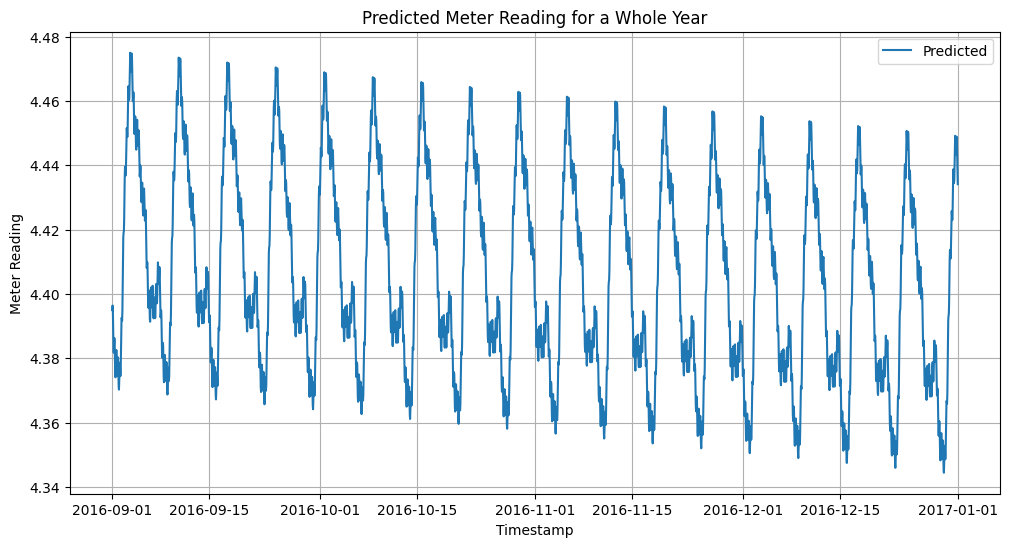

In [29]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(test_results_1['timestamp'], predicted_values1, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.title('Predicted Meter Reading for a Whole Year')
plt.legend()
plt.grid(True)
plt.show()

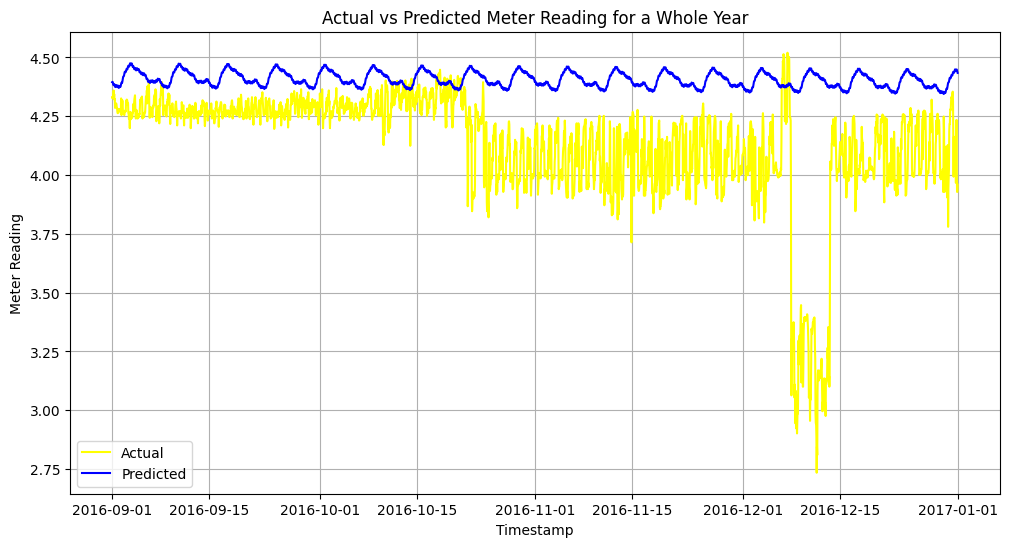

In [31]:
# plt.figure(figsize=(12, 6))
# plt.plot(test_results_1['timestamp'], test_results_1['predicted_values1'], label='Predicted')

# actual_monthly1 = test_results_1.groupby('month')['actual_values'].sum()
# predicted_monthly1 = test_results_1.groupby('month')['predicted_values'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(test_results_1['timestamp'], actual_values1, color='yellow', label='Actual')
plt.plot(test_results_1['timestamp'], predicted_values1, color='blue',label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.title('Actual vs Predicted Meter Reading for a Whole Year')
plt.legend()
plt.grid(True)
plt.show()

# plt.xlabel('Timestamp')
# plt.ylabel('Predicted Values')
# plt.title('Prophet Model Predictions')
# plt.legend()
# plt.show()

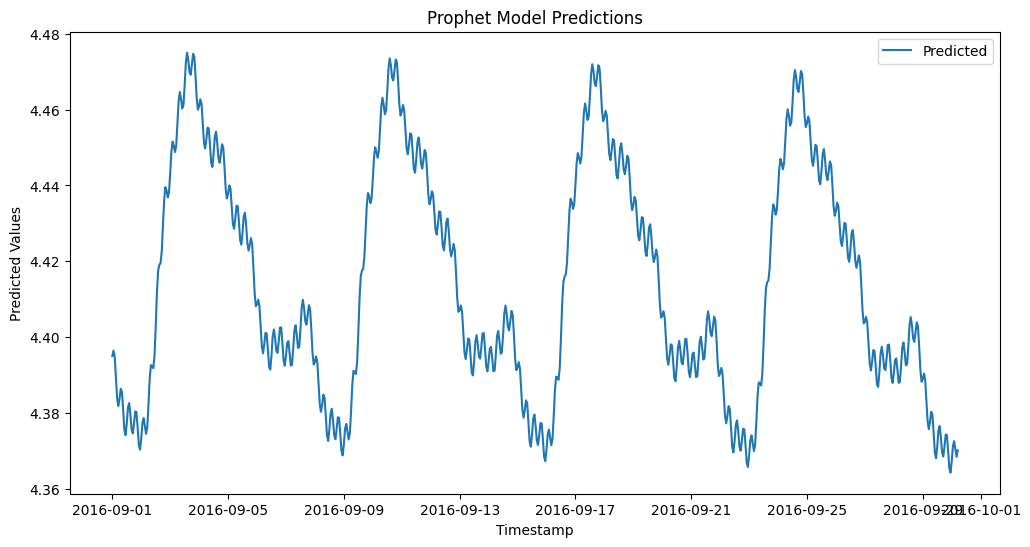

In [ ]:
end_date = '2016-09-30 05:00:00'


# Subset the arrays based on the desired end date
mask = forecast_energy['ds'] <= end_date
ds_subset = forecast_energy['ds'][mask]
predict_subset = forecast_energy['yhat'][mask]

plt.figure(figsize=(12, 6))
plt.plot(ds_subset, predict_subset, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Values')
plt.title('Prophet Model Predictions')
plt.legend()
plt.show()

# Prophet Model 2: added Holiday feature

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [24]:
cal = calendar()
holidays_train = cal.holidays(start = train_id0['timestamp'].min(), end = train_id0['timestamp'].max(), return_name=True)
holiday_df_train = pd.DataFrame(data = holidays_train, columns=['holiday'])
holiday_df_train = holiday_df_train.reset_index().rename(columns={'index':'ds'})
holiday_df_train

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-01-18,"Birthday of Martin Luther King, Jr."
2,2016-02-15,Washington’s Birthday
3,2016-05-30,Memorial Day
4,2016-07-04,Independence Day


In [25]:
cal = calendar()
holidays_test = cal.holidays(start = test_id0['timestamp'].min(), end = test_id0['timestamp'].max(), return_name=True)
holiday_df_test = pd.DataFrame(data = holidays_test, columns=['holiday'])
holiday_df_test = holiday_df_test.reset_index().rename(columns={'index':'ds'})
holiday_df_test

,ds,holiday
0,2016-09-05,Labor Day
1,2016-10-10,Columbus Day
2,2016-11-11,Veterans Day
3,2016-11-24,Thanksgiving Day
4,2016-12-26,Christmas Day


In [41]:
model_with_holidays = Prophet(holidays = holiday_df_test)
model_with_holidays.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyret2bxm/xvcue2s6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyret2bxm/zg7jfr0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8535', 'data', 'file=/tmp/tmpyret2bxm/xvcue2s6.json', 'init=/tmp/tmpyret2bxm/zg7jfr0p.json', 'output', 'file=/tmp/tmpyret2bxm/prophet_modeljh3ze4ur/prophet_model-20230612141804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:18:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Making Predictions

In [42]:
# Merge the holiday information with the test data
test_data_with_holidays = test_data.merge(holiday_df_test, on='ds', how='left')

# Make predictions using the modified test data
forecast_energy_holidays = model_with_holidays.predict(test_data_with_holidays)
forecast_energy_holidays[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

,ds,yhat_lower,yhat,yhat_upper
0,2016-09-01 00:00:00,3.959767,4.397704,4.837375
1,2016-09-01 01:00:00,3.995655,4.399125,4.830335
2,2016-09-01 02:00:00,4.011834,4.397429,4.838759
3,2016-09-01 03:00:00,3.947519,4.392048,4.826525
4,2016-09-01 04:00:00,3.889247,4.386294,4.807642
...,...,...,...,...
2923,2016-12-31 19:00:00,-5.874040,4.463721,14.486082
2924,2016-12-31 20:00:00,-5.890331,4.462761,14.536075
2925,2016-12-31 21:00:00,-5.885165,4.457565,14.425449
2926,2016-12-31 22:00:00,-5.818335,4.451475,14.541664


In [39]:
forecast_energy_holidays = model_with_holidays.predict(test_data)
forecast_energy_holidays[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

TypeError: ignored

## Model 2 Evaluation

In [43]:
actual_values2 = test_id0['meter_reading_log1p']
predicted_values2 = forecast_energy_holidays['yhat']

In [44]:
# Calculate MSE
mse2 = mean_squared_error(actual_values2, predicted_values2)
# Calculate RMSE
rmse2 = np.sqrt(mse2)
# Calculate MAPE
mape2 = mean_absolute_percentage_error(actual_values2, predicted_values2)
# Calculate MAE
mae2 = mean_absolute_error(actual_values2, predicted_values2)
# Calculate R-squared
r2_2 = r2_score(actual_values2, predicted_values2)

print("Mean Squared Error (MSE) for model 2:", mse2)
print("Root Mean Squared Error (RMSE) for model 2:", rmse2)
print("Mean Absolute Percentage Error (MAPE) for model 2:", mape2)
print("Mean Absolute Error (MAE) for model 2:", mae2)
print("R-squared for model 2:", r2_2)

Mean Squared Error (MSE) for model 2: 0.14803736869221093
Root Mean Squared Error (RMSE) for model 2: 0.3847562458131264
Mean Absolute Percentage Error (MAPE) for model 2: 7.510054986326434
Mean Absolute Error (MAE) for model 2: 0.2902881393680582
R-squared for model 2: -1.3352900757763453


In [46]:
test_results_2 = pd.DataFrame()
test_results_2 = pd.concat([test_results_2, test_id0[['timestamp', 'building_id', 'site_id', 'meter']]], axis=1)
test_results_2['actual_values'] = actual_values2
test_results_2['predicted_values'] = predicted_values2

test_results_2

,timestamp,building_id,site_id,meter,actual_values,predicted_values
0,2016-09-01 00:00:00,0,0,0,4.331021,4.397704
1,2016-09-01 01:00:00,0,0,0,4.325745,4.399125
2,2016-09-01 02:00:00,0,0,0,4.331021,4.397429
3,2016-09-01 03:00:00,0,0,0,4.331021,4.392048
4,2016-09-01 04:00:00,0,0,0,4.341492,4.386294
...,...,...,...,...,...,...
2923,2016-12-31 19:00:00,0,0,0,4.234396,4.463721
2924,2016-12-31 20:00:00,0,0,0,4.032755,4.462761
2925,2016-12-31 21:00:00,0,0,0,3.928185,4.457565
2926,2016-12-31 22:00:00,0,0,0,3.928185,4.451475


## Trends, Holidays, Weekly, Daily of Model 2

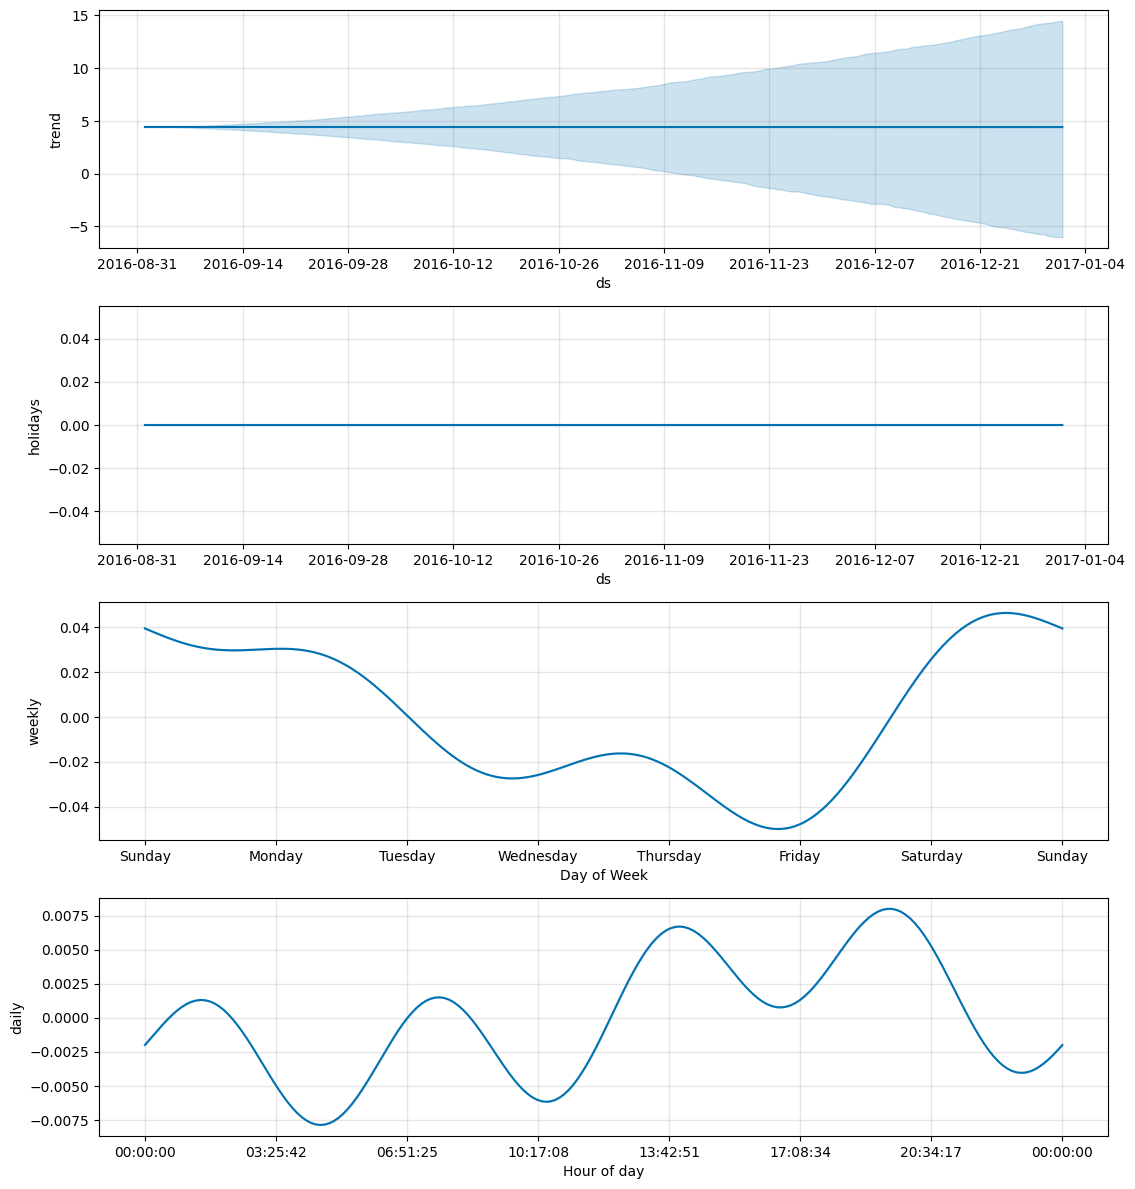

In [47]:
fig = model_with_holidays.plot_components(forecast_energy_holidays)
fig.set_figwidth(12)
plt.show()

## Predictions vs Actual

In [17]:
test_id0.set_index('timestamp', inplace=True)

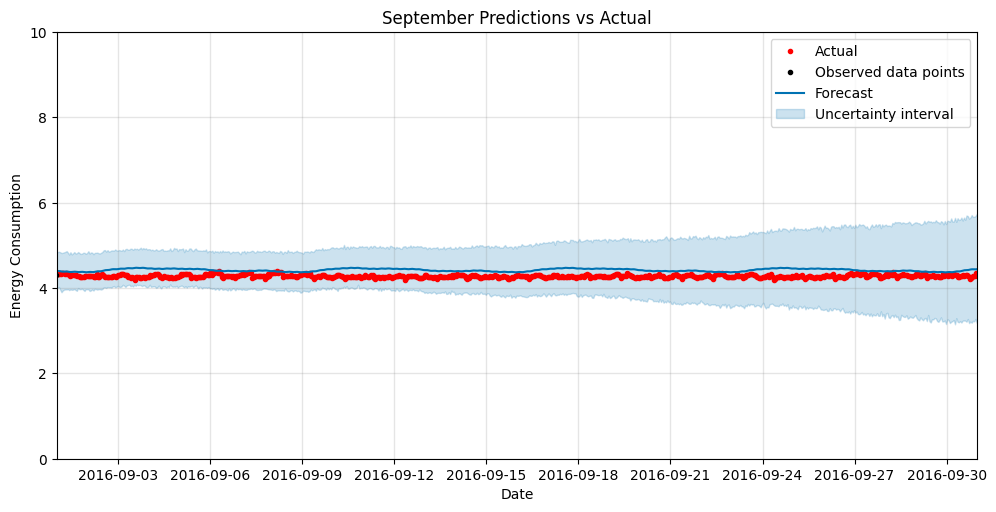

In [55]:
fig4, ax = plt.subplots(figsize=(10, 5))
# ax.plot(test_id0.index, test_id0['meter_reading_log1p'], 'r.', label='Actual')
ax.plot(test_id0['timestamp'], test_id0['meter_reading_log1p'], 'r.', label='Actual')
model_with_holidays.plot(forecast_energy_holidays, ax=ax)
ax.set_xlim(pd.to_datetime('2016-09-01'), pd.to_datetime('2016-10-01'))
ax.set_ylim(0, 10)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('September Predictions vs Actual')
plt.legend()
plt.show()

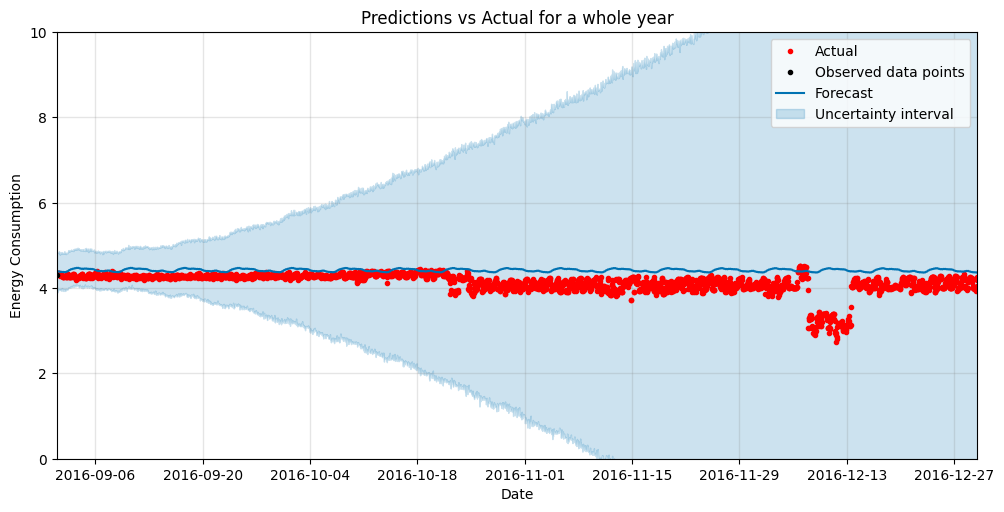

In [56]:
fig4, ax = plt.subplots(figsize=(10, 5))
# ax.plot(test_id0.index, test_id0['meter_reading_log1p'], 'r.', label='Actual')
ax.plot(test_id0['timestamp'], test_id0['meter_reading_log1p'], 'r.', label='Actual')
model_with_holidays.plot(forecast_energy_holidays, ax=ax)
ax.set_xlim(pd.to_datetime('2016-09-01'), pd.to_datetime('2016-12-30'))
ax.set_ylim(0, 10)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Predictions vs Actual for a whole year')
plt.legend()
plt.show()

# Prophet Model 3: Added regressors

In [26]:
# Create regressors DataFrame with timestamp and regressor columns
regressors = pd.DataFrame()
regressors['ds'] = train_id0['timestamp']
regressors['air_temperature'] = train_id0['air_temperature']
regressors['cloud_coverage'] = train_id0['cloud_coverage']
regressors['dew_temperature'] = train_id0['dew_temperature']
regressors['precip_depth_1_hr'] = train_id0['precip_depth_1_hr']
regressors['sea_level_pressure'] = train_id0['sea_level_pressure']
regressors['wind_speed'] = train_id0['wind_speed']


# Convert 'ds' column to datetime type
regressors['ds'] = pd.to_datetime(regressors['ds'])

# Initialize Prophet model_with_features
model_with_features = Prophet(holidays = holiday_df_train)

# Add regressors to the model_with_features
model_with_features.add_regressor('air_temperature')
model_with_features.add_regressor('cloud_coverage')
model_with_features.add_regressor('dew_temperature')
model_with_features.add_regressor('precip_depth_1_hr')
model_with_features.add_regressor('sea_level_pressure')
model_with_features.add_regressor('wind_speed')

# Add these features to train_data
train_data = train_data.merge(train_id0[['timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed']],
                              left_on='ds', right_on='timestamp', how='left')

train_data.drop('timestamp', axis=1, inplace=True)

# Fit the model with the additional regressors
model_with_features.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpez1s3rhu/ggif0i82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpez1s3rhu/jogck6qk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21147', 'data', 'file=/tmp/tmpez1s3rhu/ggif0i82.json', 'init=/tmp/tmpez1s3rhu/jogck6qk.json', 'output', 'file=/tmp/tmpez1s3rhu/prophet_model2mpo3pod/prophet_model-20230612152146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
test_id0

,site_id,building_id,meter,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,...,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,timestamp,meter_reading_log1p
0,0,0,0,7432.0,24.4,8.000000,23.3,-1.0,1013.7000,2.1,...,0,0,0,0,0,0,0,0,2016-09-01 00:00:00,4.331021
1,0,0,0,7432.0,24.4,8.000000,23.3,10.0,1014.3000,0.0,...,0,0,0,0,0,0,0,0,2016-09-01 01:00:00,4.325745
2,0,0,0,7432.0,23.9,8.000000,22.8,50.0,1013.0696,6.2,...,0,0,0,0,0,0,0,0,2016-09-01 02:00:00,4.331021
3,0,0,0,7432.0,23.9,8.000000,22.8,46.0,1015.0000,2.6,...,0,0,0,0,0,0,0,0,2016-09-01 03:00:00,4.331021
4,0,0,0,7432.0,23.3,8.000000,22.2,10.0,1015.7000,3.6,...,0,0,0,0,0,0,0,0,2016-09-01 04:00:00,4.341492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,0,0,0,7432.0,22.8,2.857143,10.0,0.0,1021.7000,5.7,...,0,0,0,0,0,0,0,0,2016-12-31 19:00:00,4.234396
2924,0,0,0,7432.0,23.3,2.857143,8.9,0.0,1021.0000,4.1,...,0,0,0,0,0,0,0,0,2016-12-31 20:00:00,4.032755
2925,0,0,0,7432.0,23.3,2.857143,10.0,0.0,1021.1000,4.1,...,0,0,0,0,0,0,0,0,2016-12-31 21:00:00,3.928185
2926,0,0,0,7432.0,22.8,2.857143,10.0,0.0,1021.1000,3.1,...,0,0,0,0,0,0,0,0,2016-12-31 22:00:00,3.928185


In [28]:
test_data

,ds,y
0,2016-09-01 00:00:00,4.331021
1,2016-09-01 01:00:00,4.325745
2,2016-09-01 02:00:00,4.331021
3,2016-09-01 03:00:00,4.331021
4,2016-09-01 04:00:00,4.341492
...,...,...
2923,2016-12-31 19:00:00,4.234396
2924,2016-12-31 20:00:00,4.032755
2925,2016-12-31 21:00:00,3.928185
2926,2016-12-31 22:00:00,3.928185


In [ ]:
test_id0.info()

In [70]:
test_id0['timestamp'] = pd.to_datetime(test_id0['timestamp'])

<ipython-input-70-96ea02a01025>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_id0['timestamp'] = pd.to_datetime(test_id0['timestamp'])


In [73]:
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [31]:
# test_data3 = pd.concat([test_data, test_id0[['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed']]], axis=1)


# test_data.drop('timestamp', axis=1, inplace=True)
# test_id0['timestamp'] = test_id0.index  # Convert the index to a column

test_data = test_data.merge(test_id0[['timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed']],
                            left_on='ds', right_on='timestamp', how='left')

# test_data.drop('timestamp', axis=1, inplace=True)  # Drop the duplicate timestamp column

In [32]:
test_data

,ds,y,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-09-01 00:00:00,4.331021,2016-09-01 00:00:00,24.4,8.000000,23.3,-1.0,1013.7000,2.1
1,2016-09-01 01:00:00,4.325745,2016-09-01 01:00:00,24.4,8.000000,23.3,10.0,1014.3000,0.0
2,2016-09-01 02:00:00,4.331021,2016-09-01 02:00:00,23.9,8.000000,22.8,50.0,1013.0696,6.2
3,2016-09-01 03:00:00,4.331021,2016-09-01 03:00:00,23.9,8.000000,22.8,46.0,1015.0000,2.6
4,2016-09-01 04:00:00,4.341492,2016-09-01 04:00:00,23.3,8.000000,22.2,10.0,1015.7000,3.6
...,...,...,...,...,...,...,...,...,...
2923,2016-12-31 19:00:00,4.234396,2016-12-31 19:00:00,22.8,2.857143,10.0,0.0,1021.7000,5.7
2924,2016-12-31 20:00:00,4.032755,2016-12-31 20:00:00,23.3,2.857143,8.9,0.0,1021.0000,4.1
2925,2016-12-31 21:00:00,3.928185,2016-12-31 21:00:00,23.3,2.857143,10.0,0.0,1021.1000,4.1
2926,2016-12-31 22:00:00,3.928185,2016-12-31 22:00:00,22.8,2.857143,10.0,0.0,1021.1000,3.1


## Making Predictions

In [33]:
forecast_energy_features = model_with_features.predict(test_data)
forecast_energy_features[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]

,ds,yhat_lower,yhat,yhat_upper
0,2016-09-01 00:00:00,3.942018,4.320520,4.728135
1,2016-09-01 01:00:00,3.899078,4.330991,4.759441
2,2016-09-01 02:00:00,3.881352,4.324087,4.732348
3,2016-09-01 03:00:00,3.935949,4.319766,4.759546
4,2016-09-01 04:00:00,3.882465,4.314853,4.702780
...,...,...,...,...
2923,2016-12-31 19:00:00,-5.683050,4.471404,14.703644
2924,2016-12-31 20:00:00,-5.655760,4.480389,14.631131
2925,2016-12-31 21:00:00,-5.562052,4.466095,14.547139
2926,2016-12-31 22:00:00,-5.791037,4.469078,14.503255


## Model 3 Evaluation

In [34]:
actual_values3 = test_id0['meter_reading_log1p']
predicted_values3 = forecast_energy_features['yhat']

In [81]:
actual_values3

0       4.331021
1       4.325745
2       4.331021
3       4.331021
4       4.341492
          ...   
2923    4.234396
2924    4.032755
2925    3.928185
2926    3.928185
2927    3.959193
Name: meter_reading_log1p, Length: 2928, dtype: float64

In [82]:
predicted_values3

0       4.325320
1       4.335604
2       4.332098
3       4.327096
4       4.323341
          ...   
2923    4.508541
2924    4.517317
2925    4.503122
2926    4.505622
2927    4.505942
Name: yhat, Length: 2928, dtype: float64

In [35]:
# Calculate MSE
mse3 = mean_squared_error(actual_values3, predicted_values3)
# Calculate RMSE
rmse3 = np.sqrt(mse3)
# Calculate MAPE
mape3 = mean_absolute_percentage_error(actual_values3, predicted_values3)
# Calculate MAE
mae3 = mean_absolute_error(actual_values3, predicted_values3)
# Calculate R-squared
r3_3 = r2_score(actual_values3, predicted_values3)

print("Mean Squared Error (MSE) for model 3:", mse3)
print("Root Mean Squared Error (RMSE) for model 3:", rmse3)
print("Mean Absolute Percentage Error (MAPE) for model 3:", mape3)
print("Mean Absolute Error (MAE) for model 3:", mae3)
print("R-squared for model 3:", r3_3)

Mean Squared Error (MSE) for model 3: 0.14611682218692157
Root Mean Squared Error (RMSE) for model 3: 0.38225230174182284
Mean Absolute Percentage Error (MAPE) for model 3: 7.467878660033129
Mean Absolute Error (MAE) for model 3: 0.28909401326512246
R-squared for model 3: -1.304993447070426


## Predictions vs Actual

In [36]:
test_results_3 = pd.DataFrame()
test_results_3 = pd.concat([test_results_3, test_id0[['timestamp', 'building_id', 'site_id', 'meter']]], axis=1)
test_results_3['actual_values'] = actual_values3
test_results_3['predicted_values'] = predicted_values3

test_results_3

,timestamp,building_id,site_id,meter,actual_values,predicted_values
0,2016-09-01 00:00:00,0,0,0,4.331021,4.320520
1,2016-09-01 01:00:00,0,0,0,4.325745,4.330991
2,2016-09-01 02:00:00,0,0,0,4.331021,4.324087
3,2016-09-01 03:00:00,0,0,0,4.331021,4.319766
4,2016-09-01 04:00:00,0,0,0,4.341492,4.314853
...,...,...,...,...,...,...
2923,2016-12-31 19:00:00,0,0,0,4.234396,4.471404
2924,2016-12-31 20:00:00,0,0,0,4.032755,4.480389
2925,2016-12-31 21:00:00,0,0,0,3.928185,4.466095
2926,2016-12-31 22:00:00,0,0,0,3.928185,4.469078


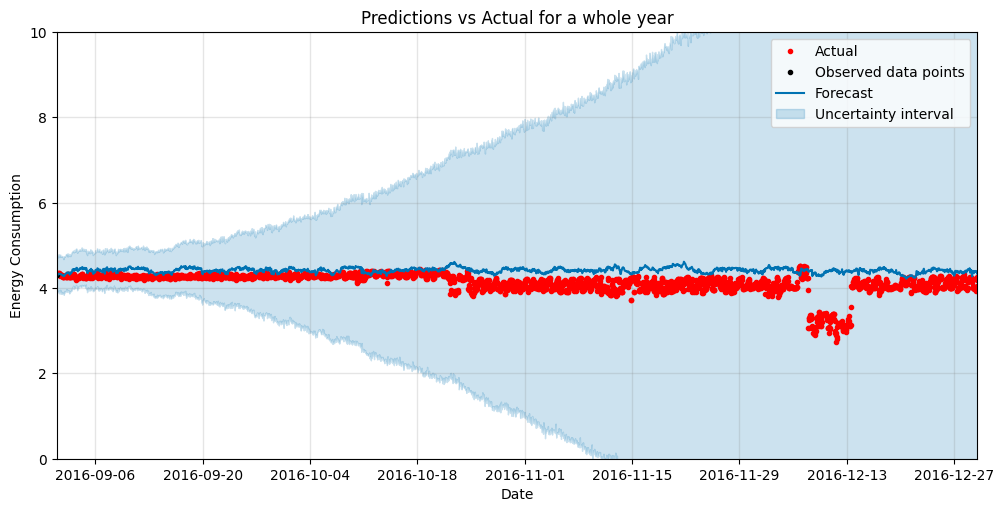

In [38]:
fig5, ax = plt.subplots(figsize=(10, 5))
# ax.plot(test_id0.index, test_id0['meter_reading_log1p'], 'r.', label='Actual')
ax.plot(test_id0['timestamp'], test_id0['meter_reading_log1p'], 'r.', label='Actual')
model_with_features.plot(forecast_energy_features, ax=ax)
ax.set_xlim(pd.to_datetime('2016-09-01'), pd.to_datetime('2016-12-30'))
ax.set_ylim(0, 10)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Predictions vs Actual for a whole year')
plt.legend()
plt.show()

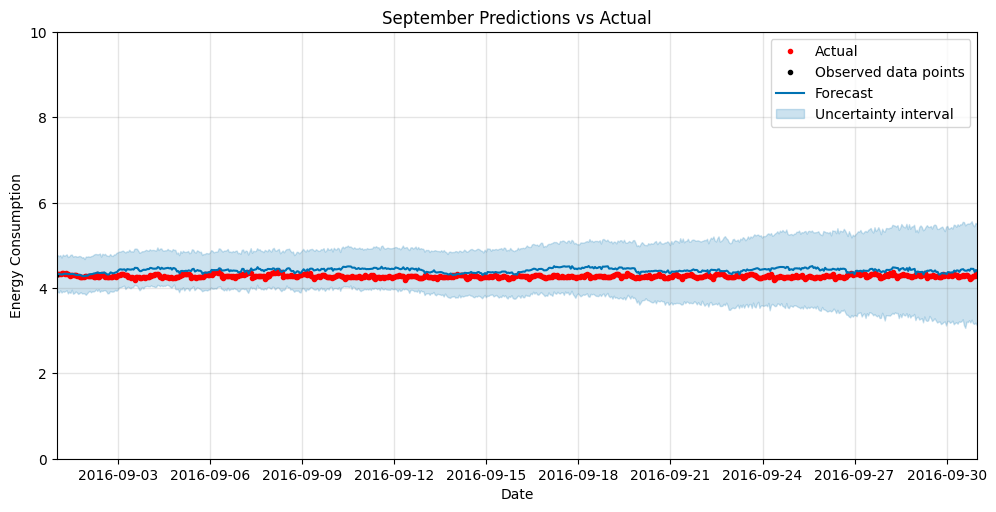

In [39]:
fig4, ax = plt.subplots(figsize=(10, 5))
# ax.plot(test_id0.index, test_id0['meter_reading_log1p'], 'r.', label='Actual')
ax.plot(test_id0['timestamp'], test_id0['meter_reading_log1p'], 'r.', label='Actual')
model_with_features.plot(forecast_energy_features, ax=ax)
ax.set_xlim(pd.to_datetime('2016-09-01'), pd.to_datetime('2016-10-01'))
ax.set_ylim(0, 10)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('September Predictions vs Actual')
plt.legend()
plt.show()

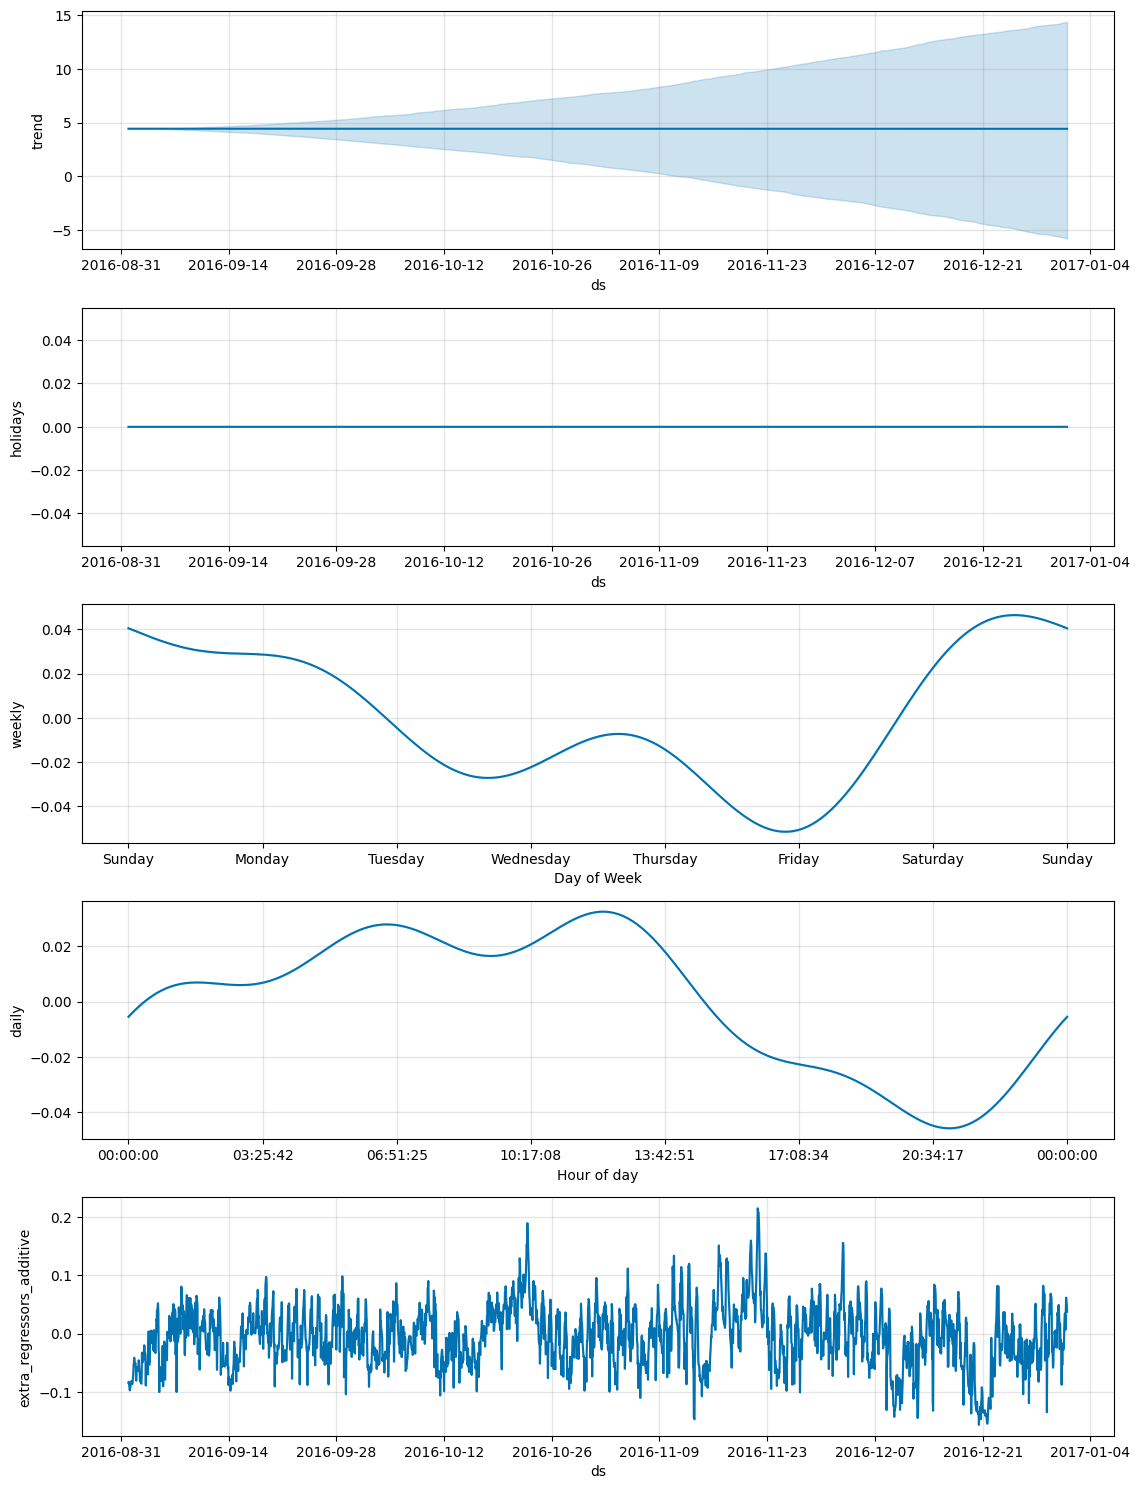

In [40]:
fig10 = model_with_features.plot_components(forecast_energy_features)
fig10.set_figwidth(12)
plt.show()